Import packages and processed run metrics

In [75]:
# packages
import os
import re
import numpy as np
import pandas as pd

# source
helper = __import__('00_helper')

# control
write_files = 1
validation_metric = 'Results/val_acc'
project_names = [
    'femnist--s02', 'sst2', 'pubmed'
    #'pubmed2'#,
    #'cifar--alpha5.0', 'cifar--alpha0.5', 'cifar--alpha0.1'
]
df = helper.load_data(project_names)

## For CIFAR
# remove_methods = [
#     method for method in df.method.unique()
#     if method not in ['fedavg', 'exact']
# ]

# Custom sorts
from pandas.api.types import CategoricalDtype
cat_method_type = CategoricalDtype(
    [
        'ditto', 'fedbn', 'fedem', 'pfedme',  # pfl-methods
        'fomaml', 'fedavg', 'exact', 'linear'  # ml-methodsd
    ],
    ordered=True
)
cat_dataset_type = CategoricalDtype(
    [
        'femnist--s02', 'sst2', 'pubmed'
    ],
    ordered=True
)


input datasets:
	 (681, 36)
	 (1320, 44)
	 (810, 37)
all runs: (2811, 44)


In [76]:
def df_to_latex(
    df,
    id_columns,
    file_name=None,
    remove_columns=None,
    file_path='output'
):

    # remove columns not of interest
    if remove_columns is None:
        remove_columns = list()
    temp_df = df[[name for name in df.columns if name not in remove_columns]]

    # sort by id columns
    temp_df = temp_df.sort_values(by=id_columns)

    # create output file
    string_df = temp_df.to_string(
        header=True,
        index=False,
        index_names=False
    )

    # remove any leading space
    string_df = re.sub('^[\s]+', '', string_df)
    # remove leading space after newlines
    string_df = re.sub('\n[\s]+', '\n', string_df)
    # replace white space between words with table column skip
    string_df = re.sub('[ \t]+', ' & ', string_df)

    # add latex newline to end of each line
    string_df = string_df.replace('_', ' ')
    string_df = string_df.replace('\n', ' \\\\\n')
    string_df = string_df + ' \\\\'

    if file_name is not None:

        # write to file
        with open(os.path.join(file_path, f'{file_name}.txt'), 'w') as f:
            f.writelines(string_df)

    else:
        return string_df


Filter data to runs of interest
Apply summary function to filtered dataset

In [77]:
row_df = df
print('input dataset:', df.shape)

## row (run) filtering
# remove extra hyper-parameter searches

row_df = row_df.loc[(row_df.n_epochs < 6)]
print('\t reduce to 3 or fewer local update steps:', row_df.shape)

row_df = row_df.loc[(row_df.K < 6) | (row_df.method != 'pfedme')]
print('\t reduce to 3 or fewer local meta-learning steps for pfedme:', row_df.shape)

row_df = row_df.loc[((10 * row_df.beta).astype('Int64') % 2 == 0) | (row_df.method != 'exact')]
print('\t reduce beta grid for decay:', row_df.shape)

## column (metric) filtering
subset_df = row_df[[
    name for name in row_df.columns
    if (
        not re.search('^sys', name)
        and not re.search('f1', name)
        and not re.search('loss', name)
    )
]]

input dataset: (2811, 44)
	 reduce to 3 or fewer local update steps: (2125, 44)
	 reduce to 3 or fewer local meta-learning steps for pfedme: (2045, 44)
	 reduce beta grid for decay: (1948, 44)


In [78]:
## get best runs for each group
# regardless of finetuning
best_runs = subset_df.loc[
    subset_df.groupby(['dataset', 'method', 'finetune']) \
    [validation_metric].idxmax()  # return index of max validation metric
]
best_runs['method'] = best_runs['method'].astype(cat_method_type)
best_runs['dataset'] = best_runs['dataset'].astype(cat_dataset_type)

# treat finetuning groups as seperate
ft_yes = best_runs.loc[best_runs.finetune == 1]
ft_no = best_runs.loc[best_runs.finetune == 0]

# best_runs.loc[[method not in remove_methods for method in best_runs.method]].head(12)
best_runs.columns

Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/test_acc',
       'Results/test_acc_bottom_decile', 'Results/test_acc_std',
       'Results/val_acc', 'Results_unseen/test_acc',
       'Results_unseen/test_acc_bottom_decile', 'Results_unseen/test_acc_std',
       'Results_weighted/test_acc', 'Results_weighted_unseen/test_acc',
       'batch_size'],
      dtype='object')

For all best runs, regardless of finetuning, produce summaries

In [79]:
# For existing users, FT since sufficient data
seen_best_runs = ft_yes[[
    name for name in ft_yes.columns
    if (
        not re.search('weighted', name)
        and not re.search('unseen', name)
    )
    or (
        not re.search('Results', name)
        or re.search('val', name)
    )
]]

if write_files:
    helper.runs_to_latex(seen_best_runs, 'seen--ft_yes')

(seen_run_summary, seen_metric_summary, seen_rank_summary) = helper.process_run_metrics(seen_best_runs)
print('all runs:', seen_run_summary.shape)
print('all metrics:', seen_metric_summary.shape)


descending metrics: ['Results/test_acc', 'Results/test_acc_bottom_decile']

ascending metrics: ['Results/test_acc_std']

id_columns Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/val_acc', 'batch_size'],
      dtype='object')
all runs: (8, 4)
all metrics: (3, 4)


In [80]:
# run summary
seen_run_summary.sort_values(by='value', ascending=False)

,,rank_one_ind,rank_two_ind,rank_three_ind,value
method,finetune,,,,
ditto,1,0,1,4,5
fedbn,1,2,3,0,5
pfedme,1,3,0,1,4
exact,1,1,3,0,4
fedem,1,1,1,1,3
fomaml,1,1,1,1,3
linear,1,1,0,2,3
fedavg,1,1,1,0,2


View processed summaries

In [81]:
# metrics summary
sort_by = ['value', 'rank_one_ind', 'rank_two_ind', 'rank_three_ind']
seen_metric_summary.sort_values(by=sort_by, ascending=False)

,rank_one_ind,rank_two_ind,rank_three_ind,value
metric,,,,
Results/test_acc_bottom_decile,2,2,2,2
Results/test_acc,1,1,1,1
Results/test_acc_std,1,1,1,1


Now seperately, based on finetuning status, repeat the above summary

In [82]:
unseen_best_runs = best_runs[[
    name for name in ft_yes.columns
    if (
               not re.search('weighted', name)
               and re.search('unseen', name)
       )
       or (
               not re.search('Results', name)
               or re.search('val', name)
       )
]]

In [83]:
ft_yes = unseen_best_runs.loc[unseen_best_runs.finetune == 1]
(yes_run_summary, yes_metric_summary, _) = helper.process_run_metrics(ft_yes)
if write_files:
    helper.runs_to_latex(ft_yes, 'unseen--ft_yes')


descending metrics: ['Results_unseen/test_acc', 'Results_unseen/test_acc_bottom_decile']

ascending metrics: ['Results_unseen/test_acc_std']

id_columns Index(['method', 'finetune', 'dataset', 's', 'n_epochs', 'lr', 'beta',
       'regular_weight', 'K', 'Results/val_acc', 'batch_size'],
      dtype='object')


In [84]:
# run summary
yes_run_summary.sort_values(by='value', ascending=False)

,,rank_one_ind,rank_two_ind,rank_three_ind,value
method,finetune,,,,
exact,1,4,0,2,6
linear,1,2,3,1,6
fedbn,1,0,2,1,3
fomaml,1,0,2,1,3
fedavg,1,1,2,0,3
fedem,1,0,1,1,2
pfedme,1,0,1,0,1
ditto,1,0,0,0,0


In [85]:
# metrics summary
yes_metric_summary.sort_values(by=sort_by, ascending=False)


,rank_one_ind,rank_two_ind,rank_three_ind,value
metric,,,,
Results_unseen/test_acc,3,3,3,3
Results_unseen/test_acc_bottom_decile,2,2,2,2
Results_unseen/test_acc_std,1,1,1,1


TEMPORARY - DECAY SCHEMES

dataset       category
method        category
test_acc       float64
bot_decile     float64
users           object
dtype: object


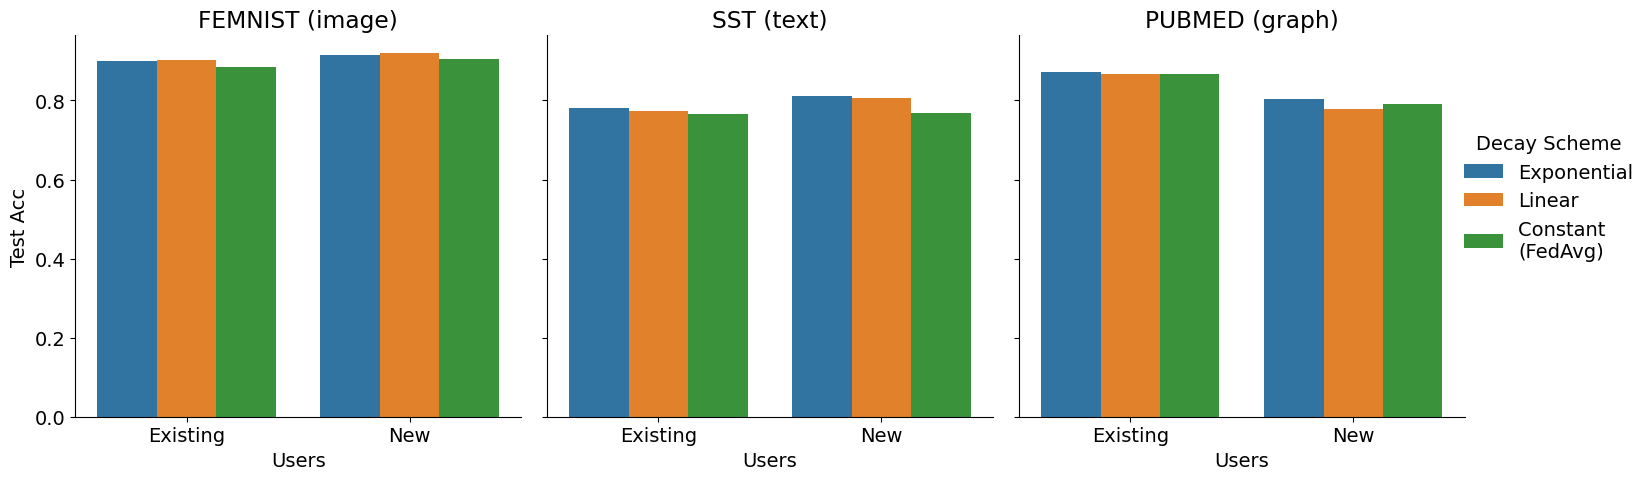

In [95]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

# data manipuilation
columns = ['dataset', 'method', 'test_acc', 'bot_decile', 'users']

temp_seen = seen_best_runs.loc[seen_best_runs.finetune == 1]
temp_seen = temp_seen[['dataset', 'method', 'Results/test_acc', 'Results/test_acc_bottom_decile']]
temp_seen['users'] = 'Existing'
temp_seen.columns = columns

temp_unseen = unseen_best_runs.loc[unseen_best_runs.finetune == 1]
temp_unseen = temp_unseen[['dataset', 'method', 'Results_unseen/test_acc', 'Results_unseen/test_acc_bottom_decile']]
temp_unseen['users'] = 'New'
temp_unseen.columns = columns

temp = pd.concat([temp_seen, temp_unseen])
temp = temp.loc[(temp.method == 'exact') | (temp.method == 'linear') | (temp.method == 'fedavg')]
cat_temp_type = CategoricalDtype(['exact', 'linear', 'fedavg'], ordered=True )
temp.method = temp.method.astype(cat_temp_type)
print(temp.dtypes)

# plot
g = sns.catplot(
    data=temp,
    y='test_acc',
    x='users', hue='method', col='dataset',
    kind='bar',
    facet_kws={'legend_out': True}
)

# edit legend
g._legend.set_title('Decay Scheme')
for h, text in zip(g._legend.texts, ['Exponential', 'Linear', 'Constant \n(FedAvg)']):
    h.set_text(text)

# set titles
axarr = g.axes.flatten()
Datasets = ['FEMNIST (image)', 'SST (text)', 'PUBMED (graph)']
for i, Dataset in enumerate(Datasets):
    if i == 0:
        axarr[i].set_ylabel('Test Acc')
    axarr[i].set_title(Dataset)
    axarr[i].set_xlabel('Users')

sns.move_legend(g, 'lower right', bbox_to_anchor=(1.02, .425))
plt.savefig('figures/decay-scheme.png', bbox_inches='tight')

TEMPORARY - SENSITIVITY ANALYSIS

In [ ]:
exact_df = row_df.loc[
    (subset_df.method == 'exact')
    & (subset_df.n_epochs <= 3)
    & (subset_df.finetune == 1)
]

exact_df.groupby(['dataset', 'beta']) \
    [validation_metric].idxmax()  # return index of max validation metric


In [ ]:
best_beta = exact_df.loc[
    exact_df.groupby(['dataset', 'beta']) \
        [validation_metric].idxmax()  # return index of max validation metric
].sort_values(by=['dataset', 'beta'])
print(best_beta.shape)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# best beta
datasets = ['femnist--s02', 'sst2', 'pubmed']
Datasets = ['FEMNIST (image)', 'SST (text)', 'PUBMED (graph)']

fig, axarr = plt.subplots(
    nrows=1, ncols=len(datasets),
    sharex=True, sharey=True,
    figsize=(4*len(datasets), 4)
)
axarr[0].set_ylabel('Test Accuracy')
for i, (dataset, Dataset) in enumerate(zip(datasets, Datasets)):
    temp_df = best_beta.loc[best_beta.dataset == dataset]
    axarr[i].set_title(Dataset)
    axarr[i].set_xlabel('Beta')
    axarr[i].plot(temp_df.beta, temp_df['Results/test_acc'], color='blue')
    axarr[i].plot(temp_df.beta, temp_df['Results_unseen/test_acc'], color='green')

custom_lines = [
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='green')
]
custom_labels = [
    'Existing Users',
    'New Users'
]
axarr[0].legend(
    custom_lines, custom_labels,
    loc='lower left'#,
    #bbox_to_anchor=(1, -.15),
    #ncol=len(datasets)
)

if write_files:
    plt.savefig('figures/sensitivity-analysis-best-beta.png')